In [34]:
## Test_Execution_Automation
#
## Developer: Sachin C Wadawadgi (TGLBSW0)
#
## Purpose: This Jupyter notebook has automatic script execution code. It connects to oracle databases 
# using your credentials and fires queries that are supplied in its feeder file and produces a report that is 
# emailed to the recipients of your choice. You will need to provide your database hostname,DB SID,your password
# email recipients. The module in this cell produces a voice and o/p terminal notification.
##
## MTB LICENSE

########################
########################
#### DO NOT MODIFY #####
########################
########################

import winsound
import time
import win32com.client

def notification(message):
    frequency = 3000  # Set Frequency To 2500 Hertz
    duration = 750  # Set Duration To 1000 ms == 1 second
    for i in range(1):
        winsound.Beep(frequency, duration)
        time.sleep(.1)
        winsound.Beep(frequency, duration)
        speaker = win32com.client.Dispatch("SAPI.SpVoice")
        speaker.Speak(message)
        print(message)



In [35]:
## Test_Execution_Automation
#
## Developer: Sachin C Wadawadgi (TGLBSW0)
#
## Purpose: The module in this cell connects to the database.
#
## MTB LICENSE

########################
########################
####  ADD SID       ####
####  AND HOSTNAME   ###
########################
########################

import pandas as pd
import cx_Oracle
import os
import matplotlib.pyplot as plt
import keyring


f = os.popen('echo %username%')
username = f.read().rstrip()

port = 1521

    
###############################################
ip_etl1d = 'acidic.mandtbank.com' 
SID_etl1d = 'ETL1D'

ip_mdm1d = 'porous.mandtbank.com' 
SID_mdm1d = 'MDM1D'
###############################################



dsn_tns_etl1d = cx_Oracle.makedsn(ip_etl1d, port, SID_etl1d)
dsn_tns_mdm1d = cx_Oracle.makedsn(ip_mdm1d, port, SID_mdm1d)


connection_etl1d = cx_Oracle.connect(username, keyring.get_password(SID_etl1d, username), dsn_tns_etl1d,encoding ="UTF-8") #ETL1D

connection_mdm1d = cx_Oracle.connect(username, keyring.get_password(SID_mdm1d, username), dsn_tns_mdm1d,encoding ="UTF-8") #MDM1D
    



    

In [36]:
## Test_Execution_Automation
#
## Developer: Sachin C Wadawadgi (TGLBSW0)
#
## Purpose: The module in this cell contains the core automation code. It reads the feeder file and runs the queries
# on Oracle databases and captures the output
#
## MTB LICENSE

########################
########################
#### DO NOT MODIFY #####
########################
########################


#%run ConnectionDetail_Dev.ipynb

try:
    path="F:\\Regression_TestCases.xlsx"
    TC=pd.read_excel(path,sheetname='Sheet1',converters={'Expected':str,'Threshold':str})
except Exception: 
    notification("There was error processing Regression test cases document!")




def sqlresult(Query,Env):
    
    
    if Env=='ETL1D':
        Q2 = pd.read_sql(Query, con=connection_etl1d)
        
    elif Env=='MDM1D':
        Q2 = pd.read_sql(Query, con=connection_mdm1d)
        
    return Q2



def automate():
    
    for i in range(0,TC['Query'].count()):
        
        Query=TC['Query'].values[i]
        Env=TC['Environment'].values[i]
        
        start = time. time()
       
        Q1 = sqlresult(Query,Env)           
        
        end = time. time()
        t=end - start
       
        TC.loc[i,'Output']=str(Q1['COUNT'].values[0])
        TC.loc[i,'Status']='Passed'
        TC.loc[i,'Execution Time (s)']=str((round(t,2)))
    
       
    
        if not pd.isnull(TC.loc[i,'Expected']):
        
            if Q1['COUNT'].values[0]==int(TC.loc[i,'Expected']):
                print('Test case '+str(i+1) +': \n\"'+TC.loc[i,'Testcase']+'\" ----> PASSED\n')
            else:
                print('Test case '+str(i+1) +': \n\"'+TC.loc[i,'Testcase']+'\" ----> FAILED\n')
                TC.loc[i,'Status']='Failed' 

        elif not pd.isnull(TC.loc[i,'Threshold']):   
                       
            if Q1['COUNT'].values[0] < int(TC.loc[i,'Threshold']):
                print('Test case '+str(i+1) +': \n\"'+TC.loc[i,'Testcase']+'\" ----> PASSED\n')
            else:
                print('Test case '+str(i+1) +': \n\"'+TC.loc[i,'Testcase']+'\" ----> FAILED\n')
                TC.loc[i,'Status']='Failed'
       
    
    TC['Expected']=TC['Expected'].fillna('')
    TC['Threshold']=TC['Threshold'].fillna('')
    TC.to_excel('F:\\Test_Results.xlsx',index=False)
    


if __name__ == '__main__':
    automate()
    TC.index += 1
 

Test case 1: 
"Compare the number of records that were loaded from each system’s files with the count of records that they sent in their strike file." ----> PASSED

Test case 2: 
"Check that each party has a party type of 'Individual' or 'Non-Individual'." ----> FAILED

Test case 3: 
"Check that count of parties coming from source without names shouldn't be greater than 2000" ----> PASSED

Test case 4: 
"Check that the percentage of CDC Records that had names which couldn't get parsed during the Stage load is not greater than 5" ----> PASSED

Test case 5: 
"Check that count of records from the source without a tax id doesn't exceed 500000" ----> PASSED

Test case 6: 
"Ensure that the exact account auto match rule for WISD silver is working correctly (i.e. no account duplicates are found)" ----> PASSED

Test case 7: 
"Check that exact rule 1 (party type, name, valid tax id) brings all the appropriate parties together" ----> FAILED

Test case 8: 
"Check Address Undermatching viz to check

In [37]:
## Test_Execution_Automation
#
## Developer: Sachin C Wadawadgi (TGLBSW0)
#
## Purpose: The module in this cell produces the HTML Report that has the test case status
#
## MTB LICENSE

########################
########################
#### DO NOT MODIFY #####
########################
########################

def color(val):
    if val =='Passed' :
        color = 'yellowgreen'
    elif val == 'Failed':
        color = 'lightcoral'  
    return 'background-color: %s' % color
    

TC2=TC
TC2=TC2.drop(['Query'],axis=1)
TC2
    
TC2.to_html('TestCase_Execution_Report.html')
html = TC2.style.applymap(color, subset=['Status']) \
         .set_table_attributes('border="1" class="dataframe table table-hover table-bordered"') \
         .set_properties(**{'font-size': '11pt', 'font-family': 'Calibri'})\
         .set_precision(3) \
         .render()

with open('TestCase_Execution_Report.html', 'w') as f:
    f.write(html)


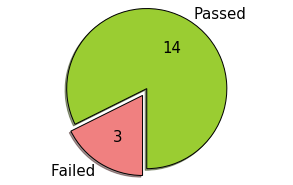

In [38]:
## Test_Execution_Automation
#
## Developer: Sachin C Wadawadgi (TGLBSW0)
#
## Purpose: The module in this code produces the Pie Chart 
#
## MTB LICENSE

########################
########################
#### DO NOT MODIFY #####
########################
########################

import matplotlib.pyplot as plt


%matplotlib inline
plt.figure(num=None, figsize=(5,3), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 15})




def absolute_value(val):
    a  = numpy.round(val/100.*sizes.sum(), 0)
    return a


Pass_Fail_Counts=TC.Status.value_counts()
Pass_Fail_Counts=Pass_Fail_Counts.to_dict()
if not 'Passed' in Pass_Fail_Counts:
    Pass_Fail_Counts['Passed']=0
elif not 'Failed' in Pass_Fail_Counts:
    Pass_Fail_Counts['Failed']=0

    
#fig = plt.figure()

labels = 'Passed','Failed'
sizes = [Pass_Fail_Counts['Passed'],Pass_Fail_Counts['Failed']]
colors = ['yellowgreen', 'lightcoral']
explode = (0, 0.1)  # explode 1st slice
Figname = 'Test_Execution_Status.jpeg'
patches, texts, autotexts = plt.pie(sizes,explode=explode, labels=labels, colors=colors,
        autopct="", shadow=True, startangle=270)

for i, a in enumerate(autotexts):
    a.set_text("{}".format(sizes[i]))

plt.axis('equal')
#plt.title('Regression Testing Result Status')


plt.savefig(Figname, dpi=100);
plt.show();


In [39]:
## Test_Execution_Automation
#
## Developer: Sachin C Wadawadgi (TGLBSW0)
#
## Purpose: The module in this cell sends an email with the testing report to the recipients
#
## MTB LICENSE

########################
########################
####  MODIFY ONLY    ###
####  EMAIL RECIPIENTS #
####  AND SUBJECT    ###  
########################
########################

import win32com.client as win32
outlook = win32.Dispatch('outlook.application')
mail = outlook.CreateItem(0)

pie_chart_file_path='C://Users//'+username+'//'+Figname

#################################################

mail.To = 'swadawadgi_contractor@mtb.com'
#mail.To = 'swadawadgi_contractor@mtb.com;aanumarlapudi_contractor@mtb.com'
mail.CC = 'swadawadgi_contractor@mtb.com'
mail.Subject = 'Regression Testing Result Status'

#################################################


with open('TestCase_Execution_Report.html', 'r') as myfile:
    data=myfile.read()

  

attachment = mail.Attachments.Add(pie_chart_file_path)
attachment.PropertyAccessor.SetProperty("http://schemas.microsoft.com/mapi/proptag/0x3712001F", "MyId1")
mail.HTMLBody = "<html><body> Detailed Report is shown below and is also in the attachment.\
 Attachment has queries for your reference.<br>\
 This is an automated email sent by Test Automation Script.<h2> Regression Testing Result Status </h2> \
<img src=""cid:MyId1""><br></body></html>"+data


attachment  = "F:\\Test_Results.xlsx"
mail.Attachments.Add(attachment)


mail.Send()
print('Total Execution time:',round(TC['Execution Time (s)'].astype(float).sum(),2))
notification('Regression Testing Completed')


Total Execution time: 46.57
Regression Testing Completed
